# Load the Data

In [1]:
from datasets import Dataset
from PIL import Image
import json
import os
import supervision as sv
import matplotlib.pyplot as plt

In [2]:
ds_path = r"C:\Users\isaac\dev\CV_Garbage_Detection\Data_Cleaned"

ds_train = sv.DetectionDataset.from_coco(
    images_directory_path=os.path.join(ds_path, "train"),
    annotations_path=os.path.join(ds_path, "train", "_annotations.coco.json"),
)

ds_test = sv.DetectionDataset.from_coco(
    images_directory_path=os.path.join(ds_path, "test"),
    annotations_path=os.path.join(ds_path, "test", "_annotations.coco.json"),
)

ds_valid = sv.DetectionDataset.from_coco(
    images_directory_path=os.path.join(ds_path, "valid"),
    annotations_path=os.path.join(ds_path, "valid", "_annotations.coco.json"),
)

In [3]:
def sv_to_custom_format(sv_dataset, class_mapping=None):    
    images, image_ids, widths, heights, objects = [], [], [], [], []  
    image_id = 0
    
    for path, _, detections in sv_dataset:
        # Load image
        img = Image.open(path)
        images.append(img)
        
        # Get image id
        image_ids.append(image_id)
        
        # Get image dimensions
        width, height = img.size
        widths.append(width)
        heights.append(height)
        
        
        # Extract object information
        object_ids, bboxes, areas, categories = [], [], [], []

        for detection in detections:
            x_min, y_min, x_max, y_max = detection[0]  # Supervision bounding box
            bbox = [x_min, y_min, x_max - x_min, y_max - y_min]
            area = (x_max - x_min) * (y_max - y_min)  # Compute area
            if detection[3] not in class_mapping.keys(): # Skip classes not in class mapping (removed classes)
                continue
            category = class_mapping[detection[3]] if class_mapping else str(detection[3])
            object_ids.append(detection[3])

            bboxes.append(bbox)
            areas.append(area)
            categories.append(category)

        objects.append({
            "id": object_ids,
            "bbox": bboxes,
            "area": areas,
            "category": categories
        })
        
        image_id += 1

    formatted_data = {
        "image": images,
        "image_id": image_ids,
        "width": widths,
        "height": heights,
        "objects": objects
    }
    return formatted_data

def get_class_mappings_from_coco(annotation_path):
    with open(annotation_path, "r") as f:
        coco_data = json.load(f)
    
    # Extract categories
    categories = coco_data["categories"]
    class_mapping = {category["id"]: category["name"] for category in categories}
    return class_mapping

In [4]:
class_mappings = get_class_mappings_from_coco(os.path.join(ds_path, "train", "_annotations.coco.json"))

label2id = {v: k for k, v in class_mappings.items()}
id2label = {k: v for k, v in class_mappings.items()}

formatted_train = sv_to_custom_format(ds_train, class_mappings)
formatted_test = sv_to_custom_format(ds_test, class_mappings)
formatted_valid = sv_to_custom_format(ds_valid, class_mappings)

In [5]:
train_dataset = Dataset.from_dict(formatted_train)
test_dataset = Dataset.from_dict(formatted_test)
valid_dataset = Dataset.from_dict(formatted_valid)

# Evaluate Data

In [6]:
print(f"Train dataset: {len(train_dataset)} images")
print(f"Test dataset: {len(test_dataset)} images")
print(f"Valid dataset: {len(valid_dataset)} images")

Train dataset: 6032 images
Test dataset: 100 images
Valid dataset: 887 images


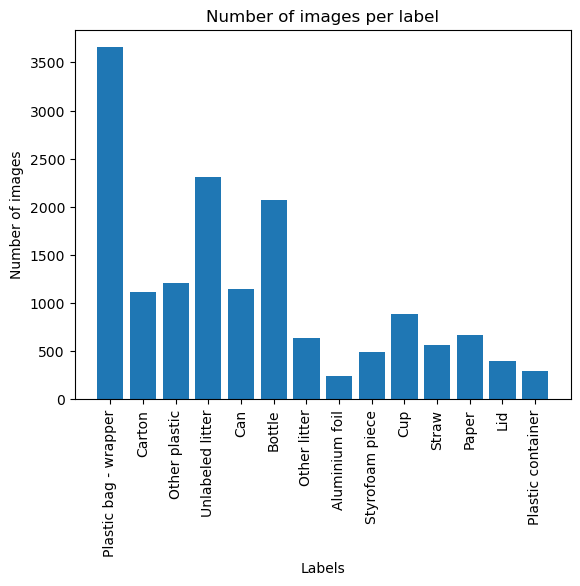

In [7]:
labels = {}
for image in train_dataset:
    for label in image["objects"]["category"]:
        if label in labels:
            labels[label] += 1
        else:
            labels[label] = 1

for image in test_dataset:
    for label in image["objects"]["category"]:
        if label in labels:
            labels[label] += 1
        else:
            labels[label] = 1

for image in valid_dataset:
    for label in image["objects"]["category"]:
        if label in labels:
            labels[label] += 1
        else:
            labels[label] = 1
            

plt.bar(labels.keys(), labels.values())
plt.xticks(rotation=90)
plt.xlabel("Labels")
plt.ylabel("Number of images")
plt.title("Number of images per label")
plt.show()


In [8]:
def calculate_average_bounding_box_size(datasets):

    total_area = 0
    bbox_count = 0

    for dataset in datasets:
        for item in dataset:
            objects = item["objects"]
            areas = objects["area"]
            total_area += sum(areas)
            bbox_count += len(areas)

    # Calculate averages
    avg_area = total_area / bbox_count if bbox_count > 0 else 0

    return avg_area, bbox_count
res = calculate_average_bounding_box_size([train_dataset, test_dataset, valid_dataset])
print("Average bounding box area:", res[0])
print("Total bounding boxes:", res[1])

Average bounding box area: 6352.911572747533
Total bounding boxes: 15705


# Load Model

In [9]:
from transformers import AutoModelForObjectDetection, AutoImageProcessor, pipeline
import torch
from PIL import ImageDraw
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [10]:
model_path = r"C:\Users\isaac\dev\CV_Garbage_Detection\Models\conditional-detr-200-epochs-new-data"

model = AutoModelForObjectDetection.from_pretrained(model_path)
processor = AutoImageProcessor.from_pretrained(model_path)

In [11]:
obj = pipeline("object-detection", model=model, image_processor=processor,device=0)

In [12]:
def draw_image_from_idx(dataset, idx):
    sample = dataset[idx]
    image = sample["image"]
    annotations = sample["objects"]
    draw = ImageDraw.Draw(image)
    width, height = sample["width"], sample["height"]

    for i in range(len(annotations["id"])):
        box = annotations["bbox"][i]
        class_idx = annotations["id"][i]
        x, y, w, h = tuple(box)
        if max(box) > 1.0:
            x1, y1 = int(x), int(y)
            x2, y2 = int(x + w), int(y + h)
        else:
            x1 = int(x * width)
            y1 = int(y * height)
            x2 = int((x + w) * width)
            y2 = int((y + h) * height)
        draw.rectangle((x1, y1, x2, y2), outline="red", width=1)
        draw.text((x1, y1), annotations["category"][i], fill="white")
    return image

def plot_results(image, results, threshold=0.7):
    image = Image.fromarray(np.uint8(image))
    draw = ImageDraw.Draw(image)
    for result in results:
        score = result["score"]
        label = result["label"]
        box = list(result["box"].values())
        if score > threshold:
            x, y, x2, y2 = tuple(box)
            draw.rectangle((x, y, x2, y2), outline="red", width=1)
            draw.text((x, y), label, fill="white")
            draw.text(
                (x + 0.5, y - 0.5),
                text=str(score),
                fill="green" if score > 0.7 else "red",
            )
    return image

# Evaluate Model Qualitatively

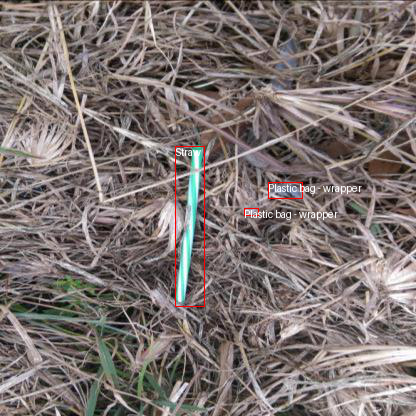

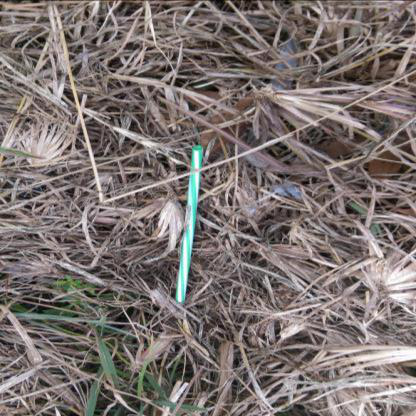

In [13]:
idx = 9
im = test_dataset[idx]["image"]
pred = obj(im)

gt = draw_image_from_idx(test_dataset, idx)
pred = plot_results(im, pred)

display(gt, pred)

# Evaluate Model Quantitatively

In [14]:
import json

all_predictions = []

for item in test_dataset:
    image = item["image"]  
    image_id = item["image_id"]         
    outputs = obj(image)
    for output in outputs:
        box = output["box"]
        x_min, y_min, x_max, y_max = box.values()
        all_predictions.append({
            "image_id": image_id,
            "category_id": label2id[output["label"]],
            "bbox": [x_min, y_min, x_max - x_min, y_max - y_min],
            "score": output["score"]
        })
        
with open("predictions.json", "w") as f:
    json.dump(all_predictions, f, indent=4)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [15]:
coco_gt = COCO(os.path.join(ds_path, "test", "_annotations.coco.json"))
coco_dt = coco_gt.loadRes("predictions.json")

coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!


In [16]:
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.337
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.290
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.109
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.337
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.391
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.213
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.114
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100

In [17]:
# Average Precision (AP) and Average Recall (AR)
ap = coco_eval.stats[0]  # AP@[IoU=0.50:0.95]
ar = coco_eval.stats[8]  # AR@[IoU=0.50:0.95]

print(f"Average Precision (AP): {ap:.4f}")
print(f"Average Recall (AR): {ar:.4f}")

Average Precision (AP): 0.2604
Average Recall (AR): 0.2992


In [18]:
print(test_dataset[12])
print(obj(test_dataset[12]["image"]))

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=416x416 at 0x1E92715B920>, 'image_id': 12, 'width': 416, 'height': 416, 'objects': {'area': [1004.25, 1111.5, 1200.0, 1055.75, 1189.0, 953.75, 1058.75, 1189.5, 1417.5, 1456.0, 1211.25, 933.75, 1211.25, 172.5, 68.25, 139.5, 160.0, 130.5, 23.75], 'bbox': [[187.0, 296.0, 51.5, 19.5], [180.0, 277.0, 57.0, 19.5], [182.0, 260.0, 60.0, 20.0], [196.0, 241.0, 51.5, 20.5], [188.0, 223.0, 58.0, 20.5], [182.0, 207.0, 54.5, 17.5], [179.0, 190.0, 60.5, 17.5], [189.0, 172.0, 61.0, 19.5], [180.0, 156.0, 81.0, 17.5], [204.0, 123.0, 56.0, 26.0], [246.0, 176.0, 25.5, 47.5], [247.0, 223.0, 22.5, 41.5], [244.0, 266.0, 25.5, 47.5], [241.0, 309.0, 15.0, 11.5], [137.0, 225.0, 6.5, 10.5], [137.0, 236.0, 9.0, 15.5], [139.0, 251.0, 16.0, 10.0], [155.0, 141.0, 14.5, 9.0], [372.0, 160.0, 9.5, 2.5]], 'category': ['Can', 'Can', 'Can', 'Can', 'Can', 'Can', 'Can', 'Can', 'Bottle', 'Can', 'Can', 'Can', 'Can', 'Unlabeled litter', 'Unlabeled litter', 'Unlab

In [19]:
def iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    union = area_box1 + area_box2 - intersection
    return intersection / union if union > 0 else 0

def eval_tpr_fpr(dataset):
    class_metrics = {cls: {'tp': 0, 'fp': 0, 'fn': 0} for cls in class_mappings.values()}
    overall_metrics = {'tp': 0, 'fp': 0, 'fn': 0}

    for item in dataset:
        gt_boxes = item["objects"]["bbox"]
        gt_boxes = [[box[0], box[1], box[0] + box[2], box[1] + box[3]] for box in gt_boxes]
        
        gt_categories = item["objects"]["category"]
        outputs = obj(item["image"])  # Predicted outputs from the model

        matched_gt = set()  # Keep track of matched ground truths

        for output in outputs:
            pred_bbox = list(output["box"].values())
            pred_cls = output["label"]

            # Calculate IoU with all ground truth boxes
            ious = [iou(pred_bbox, gt_bbox) for gt_bbox in gt_boxes]
            max_iou = max(ious)
            max_iou_idx = ious.index(max_iou)

            if max_iou >= 0.5 and gt_categories[max_iou_idx] == pred_cls:
                if max_iou_idx not in matched_gt:
                    class_metrics[pred_cls]['tp'] += 1
                    overall_metrics['tp'] += 1
                    matched_gt.add(max_iou_idx)
                else:
                    class_metrics[pred_cls]['fp'] += 1
                    overall_metrics['fp'] += 1
            else:
                class_metrics[pred_cls]['fp'] += 1
                overall_metrics['fp'] += 1

        # Count false negatives for unmatched ground truth boxes
        for i, gt_cls in enumerate(gt_categories):
            if i not in matched_gt:
                class_metrics[gt_cls]['fn'] += 1
                overall_metrics['fn'] += 1

    return class_metrics, overall_metrics
    
    

In [20]:
metrics, overall = eval_tpr_fpr(test_dataset)
print(metrics)
print(overall)

{'Litter': {'tp': 0, 'fp': 0, 'fn': 0}, 'Aluminium foil': {'tp': 6, 'fp': 1, 'fn': 0}, 'Bottle': {'tp': 12, 'fp': 3, 'fn': 14}, 'Can': {'tp': 11, 'fp': 5, 'fn': 8}, 'Carton': {'tp': 6, 'fp': 3, 'fn': 24}, 'Cup': {'tp': 10, 'fp': 0, 'fn': 9}, 'Lid': {'tp': 3, 'fp': 0, 'fn': 1}, 'Other litter': {'tp': 1, 'fp': 0, 'fn': 6}, 'Other plastic': {'tp': 3, 'fp': 7, 'fn': 25}, 'Paper': {'tp': 0, 'fp': 0, 'fn': 10}, 'Plastic bag - wrapper': {'tp': 16, 'fp': 12, 'fn': 43}, 'Plastic container': {'tp': 1, 'fp': 1, 'fn': 1}, 'Straw': {'tp': 4, 'fp': 3, 'fn': 8}, 'Styrofoam piece': {'tp': 2, 'fp': 0, 'fn': 4}, 'Unlabeled litter': {'tp': 1, 'fp': 13, 'fn': 37}}
{'tp': 76, 'fp': 48, 'fn': 190}


In [21]:
precision = overall['tp'] / (overall['tp'] + overall['fp'])
recall = overall['tp'] / (overall['tp'] + overall['fn'])
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Precision: 0.6129
Recall: 0.2857


Confusion Matrix Based on https://github.com/svpino/tf_object_detection_cm/blob/master/confusion_matrix.py

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
def generate_confusion_matrix(dataset):
    iou_threshold=0.5
    confidence_threshold=0.5
    num_classes = len(class_mappings)
    confusion_matrix = np.zeros((num_classes + 1, num_classes + 1), dtype=int)
    
    for item in dataset:
        gt_boxes = item["objects"]["bbox"]
        gt_boxes = [[box[0], box[1], box[0] + box[2], box[1] + box[3]] for box in gt_boxes]
        gt_classes = item["objects"]["id"]

        # Filter predictions based on confidence threshold
        outputs = obj(item["image"])
        detections = [
            output for output in outputs 
            if output["score"] >= confidence_threshold
        ]
        det_boxes = [list(output["box"].values()) for output in detections]
        det_classes = [label2id[output["label"]] for output in detections]

        matches = []

        # Compute IoU and match ground truth with detections
        for i, gt_box in enumerate(gt_boxes):
            for j, det_box in enumerate(det_boxes):
                iou_value = iou(gt_box, det_box)
                if iou_value >= iou_threshold:
                    matches.append([i, j, iou_value])

        matches = np.array(matches)
        if matches.shape[0] > 0:
            # Sort matches by descending IoU
            matches = matches[matches[:, 2].argsort()[::-1]]
            # Remove duplicate detections
            matches = matches[np.unique(matches[:, 1], return_index=True)[1]]
            # Remove duplicate ground truths
            matches = matches[np.unique(matches[:, 0], return_index=True)[1]]

        # Update confusion matrix for matches
        for i, gt_class in enumerate(gt_classes):
            if matches.shape[0] > 0 and matches[matches[:, 0] == i].shape[0] == 1:
                det_idx = int(matches[matches[:, 0] == i, 1][0])
                confusion_matrix[gt_class - 1][det_classes[det_idx] - 1] += 1
            else:
                # False Negative: unmatched ground truth
                confusion_matrix[gt_class - 1][-1] += 1

        # Update confusion matrix for unmatched detections
        for j, det_class in enumerate(det_classes):
            if matches.shape[0] > 0 and matches[matches[:, 1] == j].shape[0] == 0:
                # False Positive: unmatched detection
                confusion_matrix[-1][det_class - 1] += 1

    str_labels = list(class_mappings.values())

    return pd.DataFrame(
        confusion_matrix,
        index=str_labels + ["Background"],
        columns=str_labels + ["Background"]
    )

confusion_matrix = generate_confusion_matrix(test_dataset)
print(confusion_matrix)

                       Litter  Aluminium foil  Bottle  Can  Carton  Cup  Lid  \
Litter                      6               0       0    0       0    0    0   
Aluminium foil              0              12       3    0       0    0    0   
Bottle                      0               1      10    0       0    0    0   
Can                         0               0       0    6       0    0    0   
Carton                      0               0       0    0      10    0    0   
Cup                         0               0       0    0       0    3    0   
Lid                         1               0       0    0       0    0    1   
Other litter                0               0       0    0       0    0    0   
Other plastic               0               0       0    0       0    0    0   
Paper                       0               1       1    1       0    0    0   
Plastic bag - wrapper       0               0       0    1       0    0    0   
Plastic container           0           

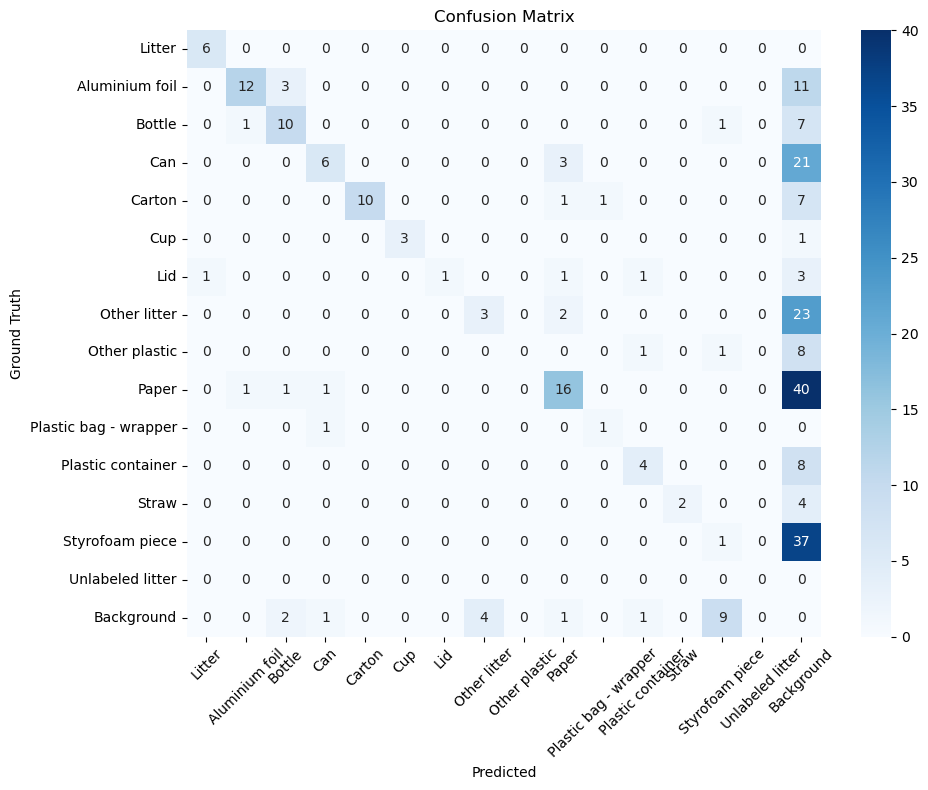

In [28]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Confusion Matrix")
plt.ylabel("Ground Truth")
plt.xlabel("Predicted")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
